In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [2]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                     self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        return np.argmax(self.q_estimation)

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.average_reward = (self.time - 1.0) / self.time * self.average_reward + reward / self.time
        self.action_count[action] += 1

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += 1.0 / self.action_count[action] * (reward - self.q_estimation[action])
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation = self.q_estimation + self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [3]:
def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in tqdm(range(runs)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

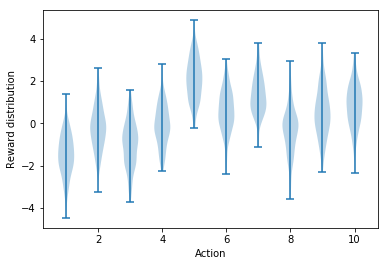

In [4]:
def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()
    
figure_2_1()

100%|██████████| 2000/2000 [00:18<00:00, 106.24it/s]


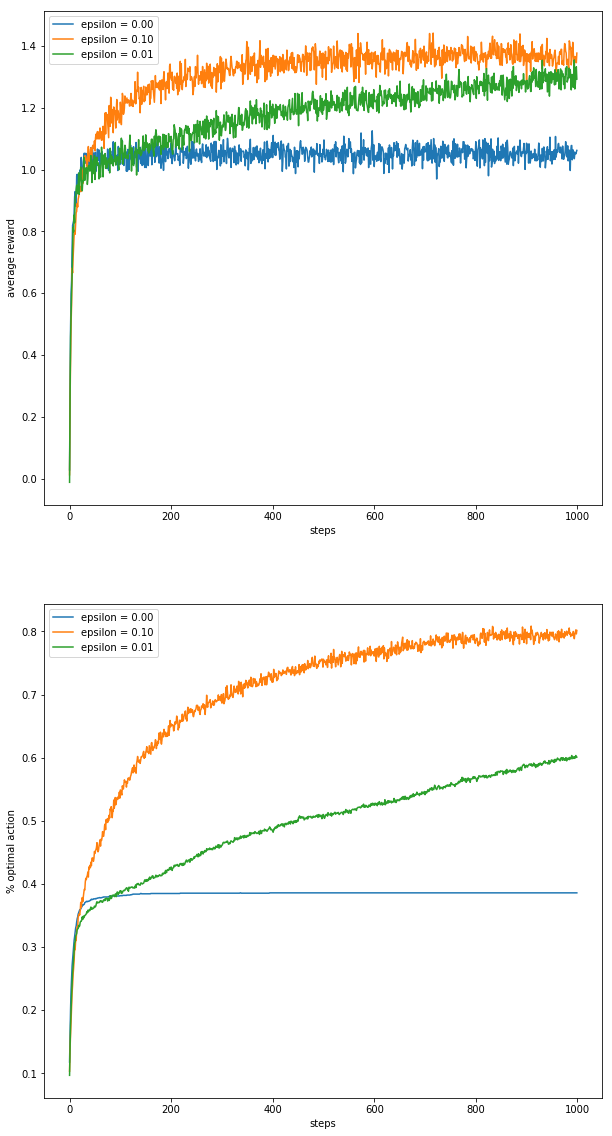

In [5]:
def figure_2_2(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()

    plt.show()
    
figure_2_2()

100%|██████████| 2000/2000 [00:17<00:00, 113.55it/s]


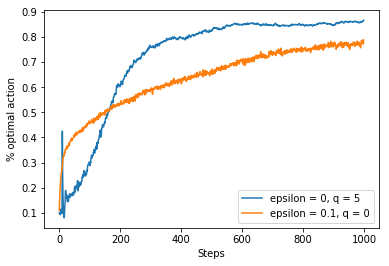

In [6]:
def figure_2_3(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
    bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
    best_action_counts, _ = simulate(runs, time, bandits)

    plt.plot(best_action_counts[0], label='epsilon = 0, q = 5')
    plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()

    plt.show()
    
figure_2_3()

100%|██████████| 2000/2000 [00:17<00:00, 111.15it/s]


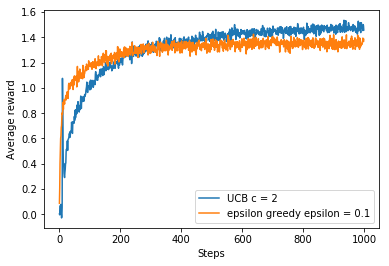

In [7]:
def figure_2_4(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)

    plt.plot(average_rewards[0], label='UCB c = 2')
    plt.plot(average_rewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.show()

figure_2_4()

100%|██████████| 2000/2000 [02:16<00:00, 14.68it/s]


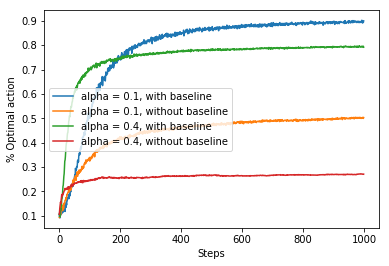

In [8]:
def figure_2_5(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.4, without baseline']

    for i in range(0, len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

    plt.show()

figure_2_5()

100%|██████████| 2000/2000 [00:16<00:00, 121.23it/s]


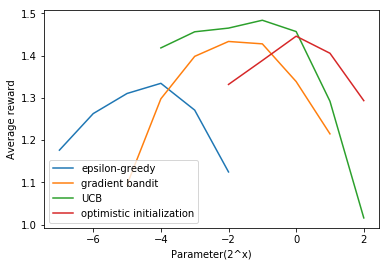

In [9]:
def figure_2_6(runs=2000, time=1000):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()

    plt.show()

figure_2_6()